In [1]:
# Tom Bresee
# Initial model - Random Forest Regressor
# Data:  Baseline (no loc features)
# Goal:  Tuning RandomForestRegressor scikit-learn mode
# Goal:  Yellowbrick enhanced / cleaner output 

<br>

In [2]:
# this notebook rendered in .html:

<br>

<br>

In [20]:
# --------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# --------------------------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) 
import seaborn as sns
# --------------------------------------------------------------------------
import glob  
from datetime import datetime as dt
import pandas_profiling
from pandas_profiling import ProfileReport
# from bokeh.layouts import column
# from bokeh.models import Div, TeX
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# --------------------------------------------------------------------------
import fiona
from sqlalchemy import create_engine
# output_notebook() # bokeh
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import yellowbrick
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import FeatureImportances

import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
cm = sns.light_palette("blue", as_cmap=True)
# correlations.style.set_caption('Correlation Values Ranked').background_gradient(cmap=cm)
# --------------------------------------------------------------------------
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.autolayout'] = True

<br>

*Read in previously downloaded .pkl of entire raw dataset*

## Random Forest Regressor

In [21]:
df_ml_3 = pd.read_pickle('use_this_data_for_gridsearch.pkl')  

In [22]:
df_ml_3.head(1).T

,0
flat_model_2-Room,0.00
flat_model_Adjoined Flat,0.00
flat_model_Apartment,0.00
flat_model_Dbss,0.00
flat_model_Improved,1.00
flat_model_Improved-Maisonette,0.00
flat_model_Maisonette,0.00
flat_model_Model A,0.00
flat_model_Model A-Maisonette,0.00
flat_model_Model A2,0.00


<BR>

### THIS IS THE ORIGINAL MODEL OUTPUT  (PRE ENHANCEMENT)

In [23]:

def MACH_L(df):
    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial.values
    y = df['price_per_sq_m_per_lease_yr_norm'].values
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               #  criterion='mse' ??? squared_error ?
                               n_estimators=200,    # locked
                               bootstrap=True,      # locked
                               max_depth= 22,       # locked 
                               max_features= 18,    # locked
                               min_samples_leaf= 2, # locked
                               min_samples_split=2, # locked (could be 3,4)
                               # max_leaf_nodes=max_leaf_nodes, #None,
                               # comment out  max_samples=None,
                               # comment out: min_weight_fraction_leaf=0.0,
                               n_jobs=-1)  
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    # print('Score ..................', rfModel.score(X_test, y_test))
    print('\n--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    # print('Score ..................', rfModel.score(X_val, y_val))
    print('\n--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    # print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')
    
    importances = rfModel.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = np.array(list(X_initial))
    # print(importances)
    
    # Print the feature ranking
    print("Feature ranking:")
        
    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))
              
    print('')
    
    visualizer = PredictionError(rfModel)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.poof()
    
    visualizer2 = ResidualsPlot(rfModel)
    visualizer2.fit(X_train, y_train)  
    visualizer2.score(X_test, y_test)
    visualizer2.poof()



--- Test Set ---
Mean Absolute Error: ... 7.357105190379599
Mean Squared Error:..... 104.88
RMSE: .................. 10.241221739791756
Coeff of det (R^2):..... 0.705

--- Val Set ---
Mean Absolute Error: ... 5.641605598502287
Mean Squared Error:..... 61.92
RMSE: .................. 7.869156277441714
Coeff of det (R^2):..... 0.836

--- Train Set ---
Mean Absolute Error: ... 3.1527835875700263
Mean Squared Error:..... 19.86
RMSE: .................. 4.45642280366845
Coeff of det (R^2):..... 0.905


Feature ranking:
1. remaining_lease_years (0.367498)
2. region_Central (0.122463)
3. lease_commence_date (0.100029)
4. floor_area_sqm (0.078654)
5. n_rooms (0.042052)
6. region_North (0.029872)
7. region_West (0.021646)
8. storey_range_max (0.015075)
9. flat_type_3 Room (0.013889)
10. storey_range_min (0.013531)
11. storey_range_avg (0.013468)
12. town_Clementi (0.013035)
13. town_Woodlands (0.012928)
14. town_Jurong West (0.011618)
15. town_Marine Parade (0.011298)
16. flat_type_5 Room (0.009

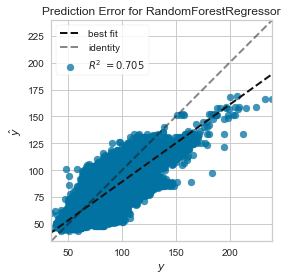

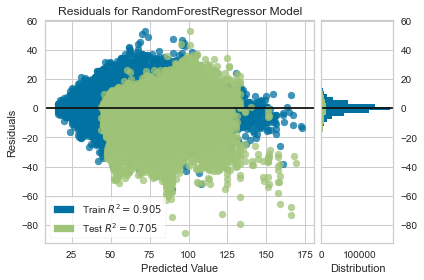

In [24]:
MACH_L(df_ml_3)

<BR><BR>

<BR><BR>

Yellowbrick extends the Scikit-Learn API to make model selection and hyperparameter tuning easier. Under the hood,
it’s using Matplotlib. 

Yellowbrick generates visualizations by wrapping matplotlib. Because of this, Yellowbrick is able to generate publication-ready images, we will create matplotlib entries to enhance the overall output, to make as clean as possible. 

In [25]:
# yellowbricks core code: 
# https://github.com/DistrictDataLabs/yellowbrick/blob/develop/yellowbrick/regressor/residuals.py

### THIS IS THE NEW (ENHANCED) OUTPUT

In [26]:

def MACH_L(df):
    
    from yellowbrick.regressor import PredictionError
    from yellowbrick.regressor import ResidualsPlot
    from yellowbrick.features import FeatureImportances

    X_initial = df.drop('price_per_sq_m_per_lease_yr_norm', axis=1)
    X = X_initial
    
    y = df['price_per_sq_m_per_lease_yr_norm']
    
    eighty_percent = 0.8 * len(df)
    ninety_percent = 0.9 * len(df)
    X_train= X[:round(eighty_percent)]
    X_val  = X[round(eighty_percent):round(ninety_percent)]
    X_test = X[round(ninety_percent):]
    y_train= y[:round(eighty_percent)]
    y_val  = y[round(eighty_percent):round(ninety_percent)]
    y_test = y[round(ninety_percent):]
    
    rf = RandomForestRegressor(random_state=42, 
                               verbose=0, 
                               #  criterion='mse' ??? squared_error ?
                               n_estimators=200,      # locked
                               bootstrap=True,        # locked
                               max_depth= 22,         # locked 
                               max_features= 18,      # locked
                               min_samples_leaf= 2,   # locked
                               min_samples_split=2,   # locked (could be 3,4)
                               # max_leaf_nodes=max_leaf_nodes, #None,
                               # comment out  max_samples=None,
                               # comment out: min_weight_fraction_leaf=0.0,
                               n_jobs=-1)  
    
    rfModel = rf.fit(X_train, y_train)
    y_pred_test = rfModel.predict(X_test)
    y_pred_train = rfModel.predict(X_train)
    y_pred_val = rfModel.predict(X_val)
    
    print('\n--- Test Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_test, y_pred_test))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_test, y_pred_test))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_test, y_pred_test))  
    # print('Score ..................', rfModel.score(X_test, y_test))
    print('\n--- Val Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_val, y_pred_val))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_val, y_pred_val))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_val, y_pred_val)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_val, y_pred_val))  
    # print('Score ..................', rfModel.score(X_val, y_val))
    print('\n--- Train Set ---')
    print('Mean Absolute Error: ...', mean_absolute_error(y_train, y_pred_train))
    print("Mean Squared Error:..... %.2f" % mean_squared_error(y_train, y_pred_train))
    print('RMSE: ..................', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("Coeff of det (R^2):..... %.3f" % r2_score(y_train, y_pred_train))  
    # print('Score ..................', rfModel.score(X_train, y_train))
    print('\n')

    plt.figure(figsize = (5,5), dpi=150)
    plt.scatter(y_test,y_pred_test, s=0.5, alpha=.7, color='green')
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()

    
    importances = rfModel.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = np.array(list(X_initial))
    # print(importances)
    
    
    # Print the feature ranking
    print("\nFeature ranking:")
    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))
    
    
    vizualizer = PredictionError(rfModel, 
                                 hist=False, 
                                 size=(1000, 700), 
                                 alpha=0.5, 
                                 dpi=200)
    
    vizualizer.fit(X_train, y_train)
    vizualizer.score(X_test, y_test)
    vizualizer.show(outpath='prediction_error_random_forest_regressor_baseline.png',
                   transparent=False)
    vizualizer.poof()
    print("")
    
    
    vizualizer2 = ResidualsPlot(rfModel, 
                                hist=False, 
                                size=(1000, 700), 
                                alpha=0.5, 
                                train_color="b",
                                test_color="maroon",
                                train_alpha=0.5,
                                test_alpha=0.5,
                                qqplot=True,
                                dpi=200)
    vizualizer2.fit(X_train, y_train)  
    vizualizer2.score(X_test, y_test)
    vizualizer2.show(outpath='residuals_random_forest_regressor_baseline.png', 
                    transparent=False)
    vizualizer2.poof()
    print("")
    

    viz3  = FeatureImportances(rfModel,  
                               size=(700, 1000), 
                               colors=['navy'],
                               alpha=0.5,
                               dpi=200)
    
    viz3.fit(X_train, y_train)
    viz3.show(outpath='feature_importances_random_forest_regressor.png', 
             transparent=False)
    viz3.poof()
    
    print('\nRandom Forest Regressor Hyperparameters:')
    pprint(rfModel.get_params())
    


--- Test Set ---
Mean Absolute Error: ... 7.357105190379599
Mean Squared Error:..... 104.88
RMSE: .................. 10.241221739791756
Coeff of det (R^2):..... 0.705

--- Val Set ---
Mean Absolute Error: ... 5.641605598502287
Mean Squared Error:..... 61.92
RMSE: .................. 7.869156277441714
Coeff of det (R^2):..... 0.836

--- Train Set ---
Mean Absolute Error: ... 3.1527835875700263
Mean Squared Error:..... 19.86
RMSE: .................. 4.45642280366845
Coeff of det (R^2):..... 0.905




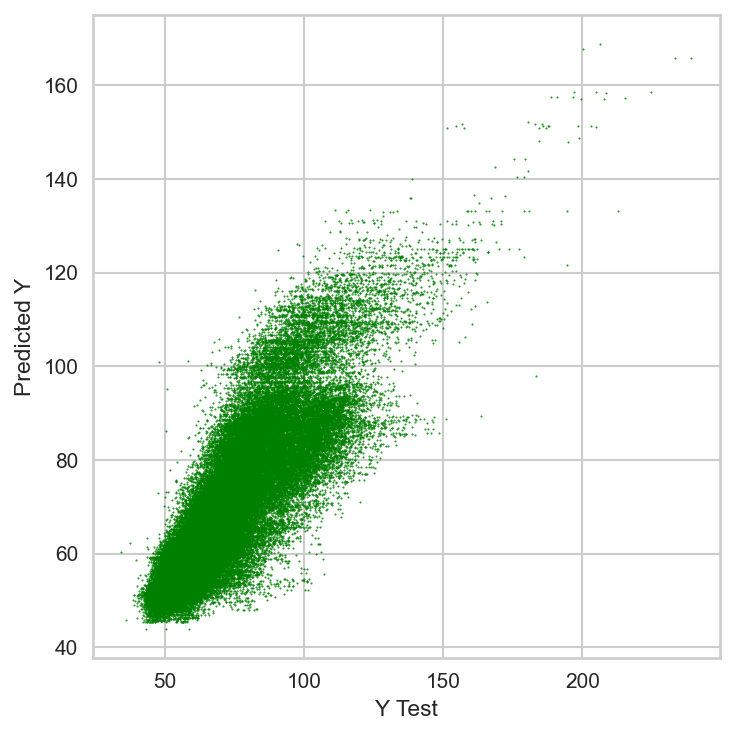


Feature ranking:
1. remaining_lease_years (0.367498)
2. region_Central (0.122463)
3. lease_commence_date (0.100029)
4. floor_area_sqm (0.078654)
5. n_rooms (0.042052)
6. region_North (0.029872)
7. region_West (0.021646)
8. storey_range_max (0.015075)
9. flat_type_3 Room (0.013889)
10. storey_range_min (0.013531)
11. storey_range_avg (0.013468)
12. town_Clementi (0.013035)
13. town_Woodlands (0.012928)
14. town_Jurong West (0.011618)
15. town_Marine Parade (0.011298)
16. flat_type_5 Room (0.009114)
17. flat_model_Standard (0.008182)
18. region_East (0.007804)
19. flat_model_Improved (0.007487)
20. flat_type_4 Room (0.007349)
21. town_Bukit Merah (0.006243)
22. town_Central Area (0.005663)
23. town_Ang Mo Kio (0.005363)
24. town_Geylang (0.005334)
25. flat_type_Executive (0.004637)
26. flat_model_New Generation (0.004471)
27. town_Bishan (0.004466)
28. flat_model_Terrace (0.004381)
29. region_North-East (0.004297)
30. town_Queenstown (0.004269)
31. flat_model_Model A (0.003833)
32. town

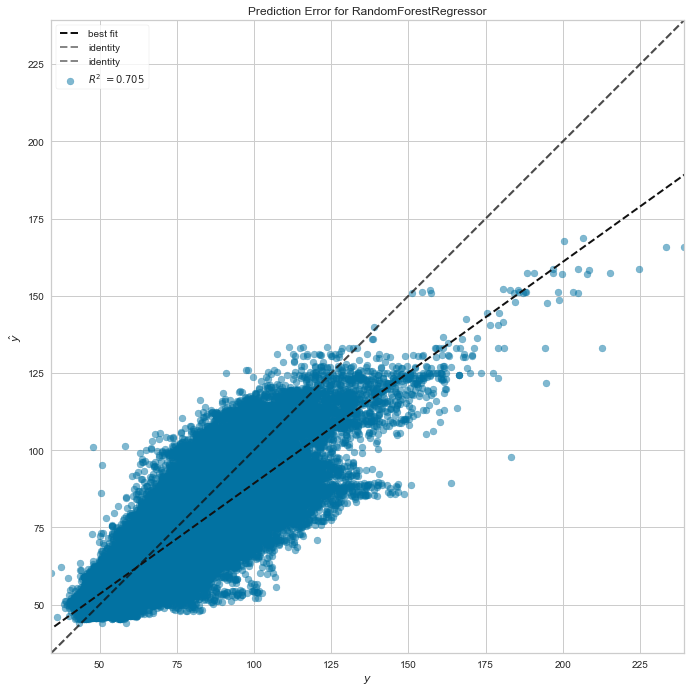

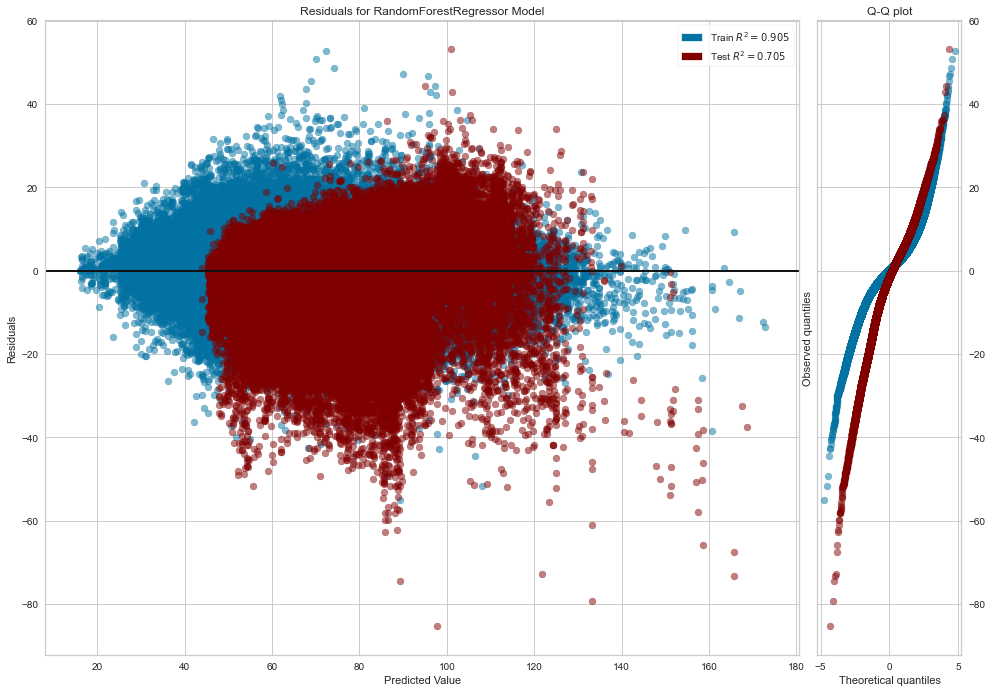

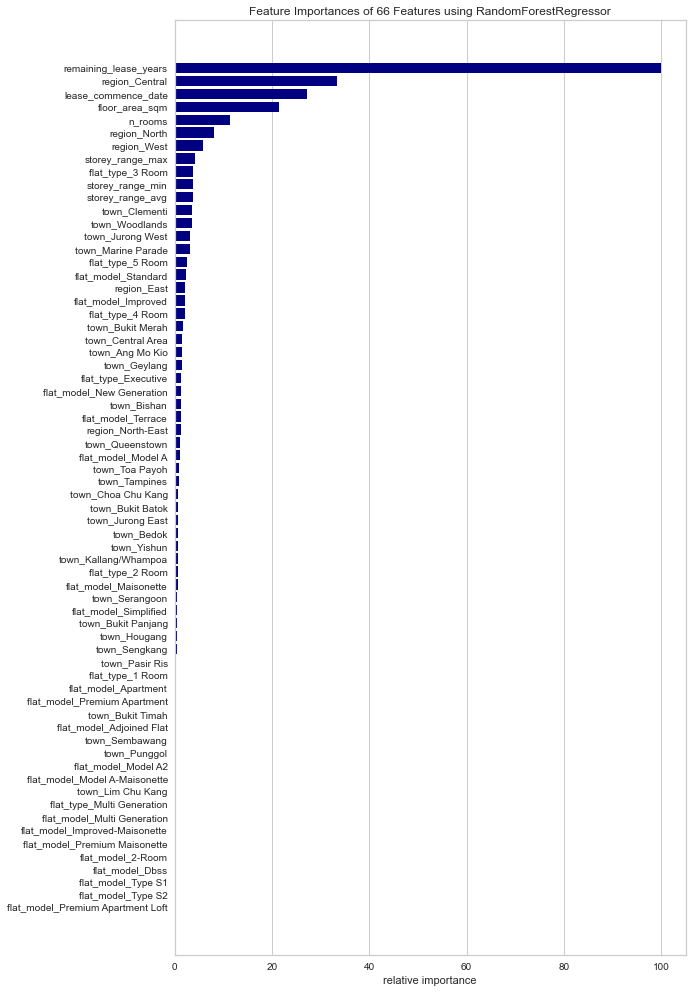


Random Forest Regressor Hyperparameters:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 22,
 'max_features': 18,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [27]:
MACH_L(df_ml_3)